In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
from operator import attrgetter
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
pd.options.mode.chained_assignment = None 
%matplotlib inline 
from datetime import date
import calendar
from calendar import monthrange

Файлы:

 olist_customers_datase.csv — таблица с уникальными идентификаторами пользователей
customer_id — позаказный идентификатор пользователя

customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)

customer_zip_code_prefix —  почтовый индекс пользователя

customer_city —  город доставки пользователя

customer_state —  штат доставки пользователя



olist_orders_dataset.csv —  таблица заказов

order_id —  уникальный идентификатор заказа (номер чека)

customer_id —  позаказный идентификатор пользователя

order_status —  статус заказа

order_purchase_timestamp —  время создания заказа

order_approved_at —  время подтверждения оплаты заказа

order_delivered_carrier_date —  время передачи заказа в логистическую службу

order_delivered_customer_date —  время доставки заказа

order_estimated_delivery_date —  обещанная дата доставки

olist_order_items_dataset.csv —  товарные позиции, входящие в заказы
order_id —  уникальный идентификатор заказа (номер чека)

order_item_id —  идентификатор товара внутри одного заказа

product_id —  ид товара (аналог штрихкода)

seller_id — ид производителя товара

shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике

price —  цена за единицу товара

freight_value —  вес товара

— Пример структуры данных можно визуализировать по order_id == 00143d0f86d6fbd9f9b38ab440ac16f5

Уникальные статусы заказов в таблице olist_orders_dataset:

created —  создан
approved —  подтверждён
invoiced —  выставлен счёт
processing —  в процессе сборки заказа
shipped —  отгружен со склада
delivered —  доставлен пользователю
unavailable —  недоступен
canceled —  отменён

In [2]:
# Загрузка данных

df_customers = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-j-postnova/first_project/olist_customers_dataset.csv')
df_orders = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-j-postnova/first_project/olist_orders_dataset.csv')
df_items = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-j-postnova/first_project/olist_order_items_dataset.csv')

In [3]:
# перевод в формат даты

df_orders['order_purchase_timestamp']  = pd.to_datetime(df_orders['order_purchase_timestamp'])
df_orders['order_approved_at'] =  pd.to_datetime (df_orders['order_approved_at'])
df_orders['order_delivered_carrier_date'] =  pd.to_datetime (df_orders['order_delivered_carrier_date'])
df_orders['order_delivered_customer_date'] = pd.to_datetime (df_orders['order_delivered_customer_date'])
df_orders['order_estimated_delivery_date'] = pd.to_datetime (df_orders['order_estimated_delivery_date'])
df_items['shipping_limit_date'] = pd.to_datetime (df_items['shipping_limit_date'])

In [4]:
df_customers.info() # проверить нулевые значения, все строки заполнены

# чем отличается customer_id от customer_unique_id???

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [5]:
df_customers.nunique() #разное количество id

customer_id                 99441
customer_unique_id          96096
customer_zip_code_prefix    14994
customer_city                4119
customer_state                 27
dtype: int64

In [6]:
df_customers.groupby("customer_unique_id", as_index=False).agg('customer_id').count().sort_values('customer_id', ascending=False)

,customer_unique_id,customer_id
52973,8d50f5eadf50201ccdcedfb9e2ac8455,17
23472,3e43e6105506432c953e165fb2acf44c,9
37797,6469f99c1f9dfae7733b25662e7f1782,7
76082,ca77025e7201e3b30c44b472ff346268,7
10354,1b6c7548a2a1f9037c1fd3ddfed95f33,7
...,...,...
32508,5657dfebff5868c4dc7e8355fea865c4,1
32507,5657596addb4d7b07b32cd330614bdf8,1
32506,5656eb169546146caeab56c3ffc3d268,1
32505,5656a8fabc8629ff96b2bc14f8c09a27,1


In [7]:
df_customers.query("customer_unique_id == '8d50f5eadf50201ccdcedfb9e2ac8455'")

#следовательно коенкретного пользователя определяет именно customer_unique_id, а customer_id - позаказный

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
14186,1bd3585471932167ab72a84955ebefea,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP
15321,a8fabc805e9a10a3c93ae5bff642b86b,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP
16654,897b7f72042714efaa64ac306ba0cafc,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP
36122,b2b13de0770e06de50080fea77c459e6,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP
38073,42dbc1ad9d560637c9c4c1533746f86d,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP
40141,dfb941d6f7b02f57a44c3b7c3fefb44b,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP
48614,65f9db9dd07a4e79b625effa4c868fcb,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP
52574,1c62b48fb34ee043310dcb233caabd2e,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP
58707,a682769c4bc10fc6ef2101337a6c83c9,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP
67996,6289b75219d757a56c0cce8d9e427900,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP


In [8]:
df_orders.info() #проверить нулевые знаения, некоторые заказы еще не переданы в слвужбу доставки, 
#не назначено время доставки, обратить внимание 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


In [9]:
df_orders['order_status'].unique() # посомтреть, какие статусы пристуствуют, все ли статусы описаны

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

In [10]:
# смерджить таблицы по customer_id
df_merged = pd.merge(df_customers, df_orders)

In [11]:
df_merged

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15
...,...,...,...,...,...,...,...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,6760e20addcf0121e9d58f2f1ff14298,delivered,2018-04-07 15:48:17,2018-04-07 16:08:45,2018-04-11 02:08:36,2018-04-13 20:06:37,2018-04-25
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2018-04-04 08:20:22,2018-04-04 08:35:12,2018-04-05 18:42:35,2018-04-11 18:54:45,2018-04-20
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,fed4434add09a6f332ea398efd656a5c,delivered,2018-04-08 20:11:50,2018-04-08 20:30:03,2018-04-09 17:52:17,2018-05-09 19:03:15,2018-05-02
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,e31ec91cea1ecf97797787471f98a8c2,delivered,2017-11-03 21:08:33,2017-11-03 21:31:20,2017-11-06 18:24:41,2017-11-16 19:58:39,2017-12-05


что будет считаться соверешнной покупкой? имеемем следующие статусы заказов, рассмотрим их подробнее:

created —  создан (все заказы с этим статусом оплачены, но не подтверждены оплаты  - в дальнейшем они могут быть отменны, следовательно совершенной покупкой их не считаем) \
approved —  подтверждён (заказы подтверждены, но не назначена дата доставки)\
invoiced —  выставлен счёт (все заказы с выставленным счетом оплачены)\
processing —  в процессе сборки заказа - оплаченные заказы, которые будут отправлены\
shipped —  отгружен со склада - переданы в слвужбу доставки\
delivered —  доставлен пользователю\
unavailable —  недоступен (оплаченные и подтвержденные заказы, но недоступные к отгрузке / не доступны клиенты? скорее всего они будут отменены и возвращены оплаты)


In [12]:
df_merged.query("order_status == 'canceled'").info() #проверяюпо по каждому статусу информацию

<class 'pandas.core.frame.DataFrame'>
Int64Index: 625 entries, 46 to 99178
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   customer_id                    625 non-null    object        
 1   customer_unique_id             625 non-null    object        
 2   customer_zip_code_prefix       625 non-null    int64         
 3   customer_city                  625 non-null    object        
 4   customer_state                 625 non-null    object        
 5   order_id                       625 non-null    object        
 6   order_status                   625 non-null    object        
 7   order_purchase_timestamp       625 non-null    datetime64[ns]
 8   order_approved_at              484 non-null    datetime64[ns]
 9   order_delivered_carrier_date   75 non-null     datetime64[ns]
 10  order_delivered_customer_date  6 non-null      datetime64[ns]
 11  order_estimated_

canceled —  отменён (часть заказов, переданных в доставку отменена, также отменены доставленные заказы - вероятно, это возвраты, отменены заказы, по которым не была произведена оплата - здесь хочется посомтреть, заказы по которым не было оплаты, какие статусы еще имеют? 

In [13]:
df_merged.query('order_approved_at.isnull()').order_status.unique() # отменены или  только созданы - понятно
                                                                    # а что здесь делает delivered?

array(['canceled', 'delivered', 'created'], dtype=object)

In [14]:
df_merged.query("order_approved_at.isnull() and order_status == 'delivered'").count()

customer_id                      14
customer_unique_id               14
customer_zip_code_prefix         14
customer_city                    14
customer_state                   14
order_id                         14
order_status                     14
order_purchase_timestamp         14
order_approved_at                 0
order_delivered_carrier_date     14
order_delivered_customer_date    14
order_estimated_delivery_date    14
dtype: int64

получили 14 заказов, которые доставлены, но не оплачены, считать ли их покупками?
может быть это какие то бесплатные досылы? Тогда стоит проверить, были ли у этих пользователей еще заказы?

In [15]:
df_merged.query("order_approved_at.isnull() and order_status == 'delivered'")

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
8970,0bf35cac6cc7327065da879e2d90fae8,c4c0011e639bdbcf26059ddc38bd3c18,13225,varzea paulista,SP,d77031d6a3c8a52f019764e68f211c69,delivered,2017-02-18 11:04:19,NaT,2017-02-23 07:23:36,2017-03-02 16:15:23,2017-03-22
13890,1e101e0daffaddce8159d25a8e53f2b2,c8822fce1d0bfa7ddf0da24fff947172,27945,macae,RJ,12a95a3c06dbaec84bcfb0e2da5d228a,delivered,2017-02-17 13:05:55,NaT,2017-02-22 11:23:11,2017-03-02 11:09:19,2017-03-20
20863,d5de688c321096d15508faae67a27051,d49f3dae6bad25d05160fc17aca5942d,36400,conselheiro lafaiete,MG,7002a78c79c519ac54022d4f8a65e6e8,delivered,2017-01-19 22:26:59,NaT,2017-01-27 11:08:05,2017-02-06 14:22:19,2017-03-16
22703,07a2a7e0f63fd8cb757ed77d4245623c,79af1bbf230a2630487975aa5d7d6220,37660,paraisopolis,MG,51eb2eebd5d76a24625b31c33dd41449,delivered,2017-02-18 15:52:27,NaT,2017-02-23 03:09:14,2017-03-07 13:57:47,2017-03-29
27441,68d081753ad4fe22fc4d410a9eb1ca01,2e0a2166aa23da2472c6a60c4af6f7a6,3573,sao paulo,SP,d69e5d356402adc8cf17e08b5033acfb,delivered,2017-02-19 01:28:47,NaT,2017-02-23 03:11:48,2017-03-02 03:41:58,2017-03-27
39286,d85919cb3c0529589c6fa617f5f43281,c094ac95fcd52f821809ec232a7a6956,95795,sao vendelino,RS,3c0b8706b065f9919d0505d3b3343881,delivered,2017-02-17 15:53:27,NaT,2017-02-22 11:31:30,2017-03-03 11:47:47,2017-03-23
41493,74bebaf46603f9340e3b50c6b086f992,f79be7c08dd24b72d34634f1b89333a4,65110,sao jose de ribamar,MA,2babbb4b15e6d2dfe95e2de765c97bce,delivered,2017-02-18 17:15:03,NaT,2017-02-22 11:23:11,2017-03-03 18:43:43,2017-03-31
44050,684cb238dc5b5d6366244e0e0776b450,6ff8b0d7b35d5c945633b8d60165691b,11030,santos,SP,c1d4211b3dae76144deccd6c74144a88,delivered,2017-01-19 12:48:08,NaT,2017-01-25 14:56:50,2017-01-30 18:16:01,2017-03-01
52849,a3d3c38e58b9d2dfb9207cab690b6310,5a4fa4919cbf2b049e72be460a380e5b,35620,abaete,MG,2eecb0d85f281280f79fa00f9cec1a95,delivered,2017-02-17 17:21:55,NaT,2017-02-22 11:42:51,2017-03-03 12:16:03,2017-03-20
60039,2127dc6603ac33544953ef05ec155771,8a9a08c7ca8900a200d83cf838a07e0b,6708,cotia,SP,e04abd8149ef81b95221e88f6ed9ab6a,delivered,2017-02-18 14:40:00,NaT,2017-02-23 12:04:47,2017-03-01 13:25:33,2017-03-17


In [16]:
df_merged.query("customer_id == '29c35fc91fc13fb5073c8f30505d860d'")

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
79535,29c35fc91fc13fb5073c8f30505d860d,7e1a5ca61b572d76b64b6688b9f96473,62700,caninde,CE,5cf925b116421afa85ee25e99b4c34fb,delivered,2017-02-18 16:48:35,NaT,2017-02-22 11:23:10,2017-03-09 07:28:47,2017-03-31


нет, эти пользователи сделали по 1 заказу

Таким образом, совершенной покупкой будем считать заказы со статусами: 
approved, invoiced, processing, shipped, delivered а также заказы, у которые была произведена оплата

# Сколько у нас пользователей, которые совершили покупку только один раз?

In [17]:
df_merged.query("order_approved_at.notnull() and order_status in \
                ['approved', 'invoiced', 'processing', 'shipped', 'delivered']")\
        .groupby('customer_id', as_index=False).agg('order_status')\
        .count()\
        .query('order_status == 1')\
        .shape[0]

98188

In [18]:
df_merged.query("order_status in \
                ['approved', 'invoiced', 'processing', 'shipped', 'delivered']")\
        .groupby('customer_id', as_index=False).agg('order_status')\
        .count()\
        .query('order_status == 1')\
        .shape[0]

98202

98188 пользователей совершили покупку 1 раз.
98202 пользователя (в том числе неоплаченные, но доставленые (14 шт.)) 

# Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

In [19]:
df_merged['month_plan_delivery'] = df_merged['order_estimated_delivery_date'].dt.month 
#сразу добавлю месяц планируемой даты доставки заказа

Под этим я бы рассматривала заказы, которые имеют статус cancelled и unavailable.

Заказы во всех остальных статусах либо находятся в работе, либо уже доставлены. 

Рассмотрим подробнее статус cancelled



In [20]:
df_merged.query("order_status == 'canceled'").info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 625 entries, 46 to 99178
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   customer_id                    625 non-null    object        
 1   customer_unique_id             625 non-null    object        
 2   customer_zip_code_prefix       625 non-null    int64         
 3   customer_city                  625 non-null    object        
 4   customer_state                 625 non-null    object        
 5   order_id                       625 non-null    object        
 6   order_status                   625 non-null    object        
 7   order_purchase_timestamp       625 non-null    datetime64[ns]
 8   order_approved_at              484 non-null    datetime64[ns]
 9   order_delivered_carrier_date   75 non-null     datetime64[ns]
 10  order_delivered_customer_date  6 non-null      datetime64[ns]
 11  order_estimated_

Среди отмененных заказов есть те, которые не были подтверждены, 
и соотвественно не доставлялись, есть заказы, которые были выданы в доставку, но не доставлены, 
а также есть заказы, которые были доставлены, но отменены.

Исходя из этого, заказы, которые были не доставлены по причине отмены я бы считала по критерию выданы в службу доставки, но не вручены. (остальные заказы пока в пути shipped)

In [21]:
df_canceled = df_merged.query("order_delivered_carrier_date.notnull() and order_delivered_customer_date.isnull() and order_status == 'canceled'")\
                    .groupby('month_plan_delivery', as_index=False).agg('customer_id').count()
df_canceled

,month_plan_delivery,customer_id
0,2,29
1,3,40


In [22]:
df_canceled.customer_id.median() #"в среднем" поэтому смотрю медиану

34.5

Рассмотрим статус unavailable

In [23]:
df_merged.query("order_status == 'unavailable'").info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 609 entries, 288 to 99105
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   customer_id                    609 non-null    object        
 1   customer_unique_id             609 non-null    object        
 2   customer_zip_code_prefix       609 non-null    int64         
 3   customer_city                  609 non-null    object        
 4   customer_state                 609 non-null    object        
 5   order_id                       609 non-null    object        
 6   order_status                   609 non-null    object        
 7   order_purchase_timestamp       609 non-null    datetime64[ns]
 8   order_approved_at              609 non-null    datetime64[ns]
 9   order_delivered_carrier_date   0 non-null      datetime64[ns]
 10  order_delivered_customer_date  0 non-null      datetime64[ns]
 11  order_estimated

Все заказы со статусом unavailable не были переданы в службу доставки, вероятно, по причине отсутсвия нужных товаров. 
Считаем сколько в среднем в месяц таких заказов

In [24]:
df_unavailable = df_merged.query("order_status == 'canceled'")\
                    .groupby('month_plan_delivery', as_index=False).agg('customer_id').count()
df_unavailable

,month_plan_delivery,customer_id
0,1,7
1,2,34
2,3,114
3,4,39
4,5,49
5,6,40
6,7,47
7,8,101
8,9,76
9,10,33


In [25]:
df_unavailable.customer_id.median() # "в среднем" поэтому смотрю медиану

43.5

In [26]:
#Посчитаем среднее количество заказов в месяц
df_merged.groupby('month_plan_delivery', as_index=False).agg('order_id').count().mean()

month_plan_delivery       6.50
order_id               8286.75
dtype: float64

In [27]:
34.5/8286*100
43.5/8286*100

0.5249818971759594

# По причне невозможности вручения/доставки заказа покупателю службой доставки, в среднем в месяц не доставляется 34.5 заказа, что составляет 0.41% от всех заказов 

# По причине недоступности товара на складе и не возможности передать заказ в доставку, в среднем в месяц не доставляется 43.5 заказа, что составляет 0.52% от всех заказов

# По каждому товару определить, в какой день недели товар чаще всего покупается.

Для этого нам потребуется таблица items, мерджим ее с покуптаелями и заказами, посмотрим, что получится

Таблица items имеет намного больше строк, 
чем таблица с orders, значит каждому заказу будет соотвествовать несколько строк из items

In [28]:
df_items.order_id.nunique() # уникальных заказов меньше, чем в таблице orders

98666

In [29]:
df_orders.order_id.nunique() #все заказы уникальны, поэтому мердж будет аутер

99441

In [30]:
df_merged2 = df_items.merge(df_orders, how = 'outer')
df_merged2

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,00010242fe8c5a6d1ba2dd792cb16214,1.0,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29
1,00018f77f2f0320c557190d7a144bdd3,1.0,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15
2,000229ec398224ef6ca0657da4fc703e,1.0,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05
3,00024acbcdf0a6daa1e931b038114c75,1.0,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20
4,00042b26cf59d7ce69dfabb4e55b4fd9,1.0,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113420,aaab15da689073f8f9aa978a390a69d1,NaN,NaN,NaN,NaT,NaN,NaN,df20748206e4b865b2f14a5eabbfcf34,unavailable,2018-01-16 14:27:59,2018-01-17 03:37:34,NaT,NaT,2018-02-06
113421,3a3cddda5a7c27851bd96c3313412840,NaN,NaN,NaN,NaT,NaN,NaN,0b0d6095c5555fe083844281f6b093bb,canceled,2018-08-31 16:13:44,NaT,NaT,NaT,2018-10-01
113422,a89abace0dcc01eeb267a9660b5ac126,NaN,NaN,NaN,NaT,NaN,NaN,2f0524a7b1b3845a1a57fcf3910c4333,canceled,2018-09-06 18:45:47,NaT,NaT,NaT,2018-09-27
113423,a69ba794cc7deb415c3e15a0a3877e69,NaN,NaN,NaN,NaT,NaN,NaN,726f0894b5becdf952ea537d5266e543,unavailable,2017-08-23 16:28:04,2017-08-28 15:44:47,NaT,NaT,2017-09-15


In [31]:
df_merged2.query("order_item_id.isnull()") # среди заказов, по которым нет данных о товарах, есть заказы с 5 разными статусами,
#вероятно, при сборе данных произошла ошибка, но все же учитывать их будем

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
112650,8e24261a7e58791d10cb1bf9da94df5c,NaN,NaN,NaN,NaT,NaN,NaN,64a254d30eed42cd0e6c36dddb88adf0,unavailable,2017-11-16 15:09:28,2017-11-16 15:26:57,NaT,NaT,2017-12-05
112651,c272bcd21c287498b4883c7512019702,NaN,NaN,NaN,NaT,NaN,NaN,9582c5bbecc65eb568e2c1d839b5cba1,unavailable,2018-01-31 11:31:37,2018-01-31 14:23:50,NaT,NaT,2018-02-16
112652,37553832a3a89c9b2db59701c357ca67,NaN,NaN,NaN,NaT,NaN,NaN,7607cd563696c27ede287e515812d528,unavailable,2017-08-14 17:38:02,2017-08-17 00:15:18,NaT,NaT,2017-09-05
112653,d57e15fb07fd180f06ab3926b39edcd2,NaN,NaN,NaN,NaT,NaN,NaN,470b93b3f1cde85550fc74cd3a476c78,unavailable,2018-01-08 19:39:03,2018-01-09 07:26:08,NaT,NaT,2018-02-06
112654,00b1cb0320190ca0daa2c88b35206009,NaN,NaN,NaN,NaT,NaN,NaN,3532ba38a3fd242259a514ac2b6ae6b6,canceled,2018-08-28 15:26:39,NaT,NaT,NaT,2018-09-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113420,aaab15da689073f8f9aa978a390a69d1,NaN,NaN,NaN,NaT,NaN,NaN,df20748206e4b865b2f14a5eabbfcf34,unavailable,2018-01-16 14:27:59,2018-01-17 03:37:34,NaT,NaT,2018-02-06
113421,3a3cddda5a7c27851bd96c3313412840,NaN,NaN,NaN,NaT,NaN,NaN,0b0d6095c5555fe083844281f6b093bb,canceled,2018-08-31 16:13:44,NaT,NaT,NaT,2018-10-01
113422,a89abace0dcc01eeb267a9660b5ac126,NaN,NaN,NaN,NaT,NaN,NaN,2f0524a7b1b3845a1a57fcf3910c4333,canceled,2018-09-06 18:45:47,NaT,NaT,NaT,2018-09-27
113423,a69ba794cc7deb415c3e15a0a3877e69,NaN,NaN,NaN,NaT,NaN,NaN,726f0894b5becdf952ea537d5266e543,unavailable,2017-08-23 16:28:04,2017-08-28 15:44:47,NaT,NaT,2017-09-15


In [32]:
df_merged2.query("order_item_id.isnull()")['order_status'].unique()

array(['unavailable', 'canceled', 'created', 'shipped', 'invoiced'],
      dtype=object)

In [33]:
df_merged2.groupby('order_id', as_index=False).agg('product_id').count().sort_values('product_id', ascending = False)
#найдем заказ с самым больши количестов продуктов

,order_id,product_id
50543,8272b63d03f5f79c56e9e4120aec44ef,21
10541,1b15974a0141d54e36626dca3fdc731a,20
66248,ab14fdcfbe524636d65ee38360e22ce8,20
61436,9ef13efd6949e4573a18964dd1bbe7f5,15
25797,428a2f660dc84138d969ccd69a0ab6d5,15
...,...,...
89940,e744792a1abc89d92d36e086697eaf97,0
91994,ecae73914f65a01db35cc609281364ef,0
60054,9b932dca249f9971b86dde2f2d7ad412,0
41232,6a30e349ceba14fcd64f13c3fd62aed3,0


In [34]:
df_merged2.query ("order_id == '8272b63d03f5f79c56e9e4120aec44ef'") 
# следовательно для каждого заказа отдельной строкой дана ифномрация по купленному товару. 

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
57297,8272b63d03f5f79c56e9e4120aec44ef,1.0,270516a3f41dc035aa87d220228f844c,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89,fc3d1daec319d62d49bfb5e1f83123e9,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,2017-07-31 18:03:02,2017-07-28
57298,8272b63d03f5f79c56e9e4120aec44ef,2.0,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89,fc3d1daec319d62d49bfb5e1f83123e9,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,2017-07-31 18:03:02,2017-07-28
57299,8272b63d03f5f79c56e9e4120aec44ef,3.0,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89,fc3d1daec319d62d49bfb5e1f83123e9,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,2017-07-31 18:03:02,2017-07-28
57300,8272b63d03f5f79c56e9e4120aec44ef,4.0,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89,fc3d1daec319d62d49bfb5e1f83123e9,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,2017-07-31 18:03:02,2017-07-28
57301,8272b63d03f5f79c56e9e4120aec44ef,5.0,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89,fc3d1daec319d62d49bfb5e1f83123e9,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,2017-07-31 18:03:02,2017-07-28
57302,8272b63d03f5f79c56e9e4120aec44ef,6.0,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89,fc3d1daec319d62d49bfb5e1f83123e9,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,2017-07-31 18:03:02,2017-07-28
57303,8272b63d03f5f79c56e9e4120aec44ef,7.0,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89,fc3d1daec319d62d49bfb5e1f83123e9,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,2017-07-31 18:03:02,2017-07-28
57304,8272b63d03f5f79c56e9e4120aec44ef,8.0,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89,fc3d1daec319d62d49bfb5e1f83123e9,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,2017-07-31 18:03:02,2017-07-28
57305,8272b63d03f5f79c56e9e4120aec44ef,9.0,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89,fc3d1daec319d62d49bfb5e1f83123e9,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,2017-07-31 18:03:02,2017-07-28
57306,8272b63d03f5f79c56e9e4120aec44ef,10.0,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89,fc3d1daec319d62d49bfb5e1f83123e9,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,2017-07-31 18:03:02,2017-07-28


In [35]:
df_merged2['order_weekday'] = df_merged2.order_purchase_timestamp.apply(lambda x: x.strftime('%A'))
df_merged2
#Добавляю столбец с днем недели

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_weekday
0,00010242fe8c5a6d1ba2dd792cb16214,1.0,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,Wednesday
1,00018f77f2f0320c557190d7a144bdd3,1.0,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,Wednesday
2,000229ec398224ef6ca0657da4fc703e,1.0,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,Sunday
3,00024acbcdf0a6daa1e931b038114c75,1.0,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,Wednesday
4,00042b26cf59d7ce69dfabb4e55b4fd9,1.0,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,Saturday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113420,aaab15da689073f8f9aa978a390a69d1,NaN,NaN,NaN,NaT,NaN,NaN,df20748206e4b865b2f14a5eabbfcf34,unavailable,2018-01-16 14:27:59,2018-01-17 03:37:34,NaT,NaT,2018-02-06,Tuesday
113421,3a3cddda5a7c27851bd96c3313412840,NaN,NaN,NaN,NaT,NaN,NaN,0b0d6095c5555fe083844281f6b093bb,canceled,2018-08-31 16:13:44,NaT,NaT,NaT,2018-10-01,Friday
113422,a89abace0dcc01eeb267a9660b5ac126,NaN,NaN,NaN,NaT,NaN,NaN,2f0524a7b1b3845a1a57fcf3910c4333,canceled,2018-09-06 18:45:47,NaT,NaT,NaT,2018-09-27,Thursday
113423,a69ba794cc7deb415c3e15a0a3877e69,NaN,NaN,NaN,NaT,NaN,NaN,726f0894b5becdf952ea537d5266e543,unavailable,2017-08-23 16:28:04,2017-08-28 15:44:47,NaT,NaT,2017-09-15,Wednesday


In [36]:
#Посчитаем количество продаж для каждого товара в каждый день недели

df_week_sells = df_merged2.groupby(['product_id', 'order_weekday']).agg('order_item_id')\
    .count().reset_index()\
    .sort_values(['product_id', 'order_item_id'], ascending=False)

Предполагая, что каждый товар может продаваться одинаковое количество раз в несколько дней, 
удобнее всего сделать сводную таблицу продаж по дням

In [37]:
best_sells_days = pd.DataFrame(pd.pivot_table(df_week_sells, index='product_id',\
                                    columns =  'order_weekday', \
                                    values='order_item_id').fillna(0).reset_index())
best_sells_days

order_weekday,product_id,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,00066f42aeeb9f3007548bb9d3f33c38,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,00088930e925c41fd95ebfe695fd2655,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0009406fd7479715e4bef61dd91f2462,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,000b8f95fcb9e0096488278317764d19,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,000d9be29b5207b54e86aa1b1ac54872,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
32946,fff6177642830a9a94a0f2cba5e476d1,0.0,0.0,1.0,1.0,0.0,0.0,0.0
32947,fff81cc3158d2725c0655ab9ba0f712c,0.0,1.0,0.0,0.0,0.0,0.0,0.0
32948,fff9553ac224cec9d15d49f5a263411f,1.0,0.0,0.0,0.0,0.0,0.0,0.0
32949,fffdb2d0ec8d6a61f0a0a0db3f25b441,1.0,0.0,0.0,1.0,1.0,2.0,0.0


Но если отвечать прямо на поставленнный вопрос, то также можно сделать таблицу с данными, в какой/какие дни недеи чаще покупается, то делаем следующее:

In [38]:
best_sells_days['max_sells_days'] = [best_sells_days.columns[i].tolist() for i in best_sells_days.values == best_sells_days.max(axis=1)[:,None]]

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """Entry point for launching an IPython kernel.


In [39]:
best_sells_days # теперь по каждому товару сразу видно, в какие дни он продается чаще всего

order_weekday,product_id,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,max_sells_days
0,00066f42aeeb9f3007548bb9d3f33c38,0.0,0.0,0.0,1.0,0.0,0.0,0.0,[Sunday]
1,00088930e925c41fd95ebfe695fd2655,0.0,0.0,0.0,0.0,0.0,1.0,0.0,[Tuesday]
2,0009406fd7479715e4bef61dd91f2462,0.0,0.0,0.0,0.0,1.0,0.0,0.0,[Thursday]
3,000b8f95fcb9e0096488278317764d19,1.0,0.0,0.0,0.0,0.0,0.0,1.0,"[Friday, Wednesday]"
4,000d9be29b5207b54e86aa1b1ac54872,0.0,0.0,0.0,0.0,0.0,1.0,0.0,[Tuesday]
...,...,...,...,...,...,...,...,...,...
32946,fff6177642830a9a94a0f2cba5e476d1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,"[Saturday, Sunday]"
32947,fff81cc3158d2725c0655ab9ba0f712c,0.0,1.0,0.0,0.0,0.0,0.0,0.0,[Monday]
32948,fff9553ac224cec9d15d49f5a263411f,1.0,0.0,0.0,0.0,0.0,0.0,0.0,[Friday]
32949,fffdb2d0ec8d6a61f0a0a0db3f25b441,1.0,0.0,0.0,1.0,1.0,2.0,0.0,[Tuesday]


# Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. 

Добавим месяц, год и количество дней в этом месяце, а также колчиество недель

In [40]:
df_merged['month_order'] = df_merged['order_purchase_timestamp'].apply(lambda x: x.month)
df_merged['year'] = df_merged['order_purchase_timestamp'].apply(lambda time: time.year) 
#определим месяц и год заказа

In [41]:
for i in range(len(df_merged['order_id'])):
    df_merged['days'] = monthrange(df_merged['year'][i] , df_merged['month_order'][i])[1]
df_merged ['weeks_in_month'] = round(df_merged['days'] / 7, 2)
df_merged 
# получим количество дней в конкретном месяце конкретного года и разделим на 7 - так получится количество недель

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,month_plan_delivery,month_order,year,days,weeks_in_month
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,6,5,2017,31,4.43
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,2,1,2018,31,4.43
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,6,5,2018,31,4.43
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,4,3,2018,31,4.43
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,8,7,2018,31,4.43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,6760e20addcf0121e9d58f2f1ff14298,delivered,2018-04-07 15:48:17,2018-04-07 16:08:45,2018-04-11 02:08:36,2018-04-13 20:06:37,2018-04-25,4,4,2018,31,4.43
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2018-04-04 08:20:22,2018-04-04 08:35:12,2018-04-05 18:42:35,2018-04-11 18:54:45,2018-04-20,4,4,2018,31,4.43
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,fed4434add09a6f332ea398efd656a5c,delivered,2018-04-08 20:11:50,2018-04-08 20:30:03,2018-04-09 17:52:17,2018-05-09 19:03:15,2018-05-02,5,4,2018,31,4.43
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,e31ec91cea1ecf97797787471f98a8c2,delivered,2017-11-03 21:08:33,2017-11-03 21:31:20,2017-11-06 18:24:41,2017-11-16 19:58:39,2017-12-05,12,11,2017,31,4.43


Группируем по пользователям, году и меясцу, считаем количество заказов в месяц и делим на количество недель в месяце,
получаем среднее значение 

In [42]:
df_orders_per_month = df_merged.groupby(['customer_unique_id', 'month_order', 'year','weeks_in_month'], \
                                         as_index=False).agg('order_id').nunique()
df_orders_per_month ['avg_orders_per_week'] = round(df_orders_per_month['order_id']/df_orders_per_month['weeks_in_month'], 2)
df_orders_per_month.sort_values('avg_orders_per_week', ascending=False)

,customer_unique_id,month_order,year,weeks_in_month,order_id,avg_orders_per_week
7325,12f5d6e1cbf93dafd9dcc19095df0b3d,1,2017,4.43,6,1.35
50622,83e7958a94bd7f74a9414d8782f87628,1,2017,4.43,4,0.90
76793,c8460e4251689ba205045f3ea17884a1,8,2018,4.43,4,0.90
67755,b08fab27d47a1eb6deda07bfd965ad43,9,2017,4.43,4,0.90
23941,3e43e6105506432c953e165fb2acf44c,2,2018,4.43,4,0.90
...,...,...,...,...,...,...
32869,55a08a9545274dc36a0c5804389217d4,3,2017,4.43,1,0.23
32868,55a03f067a142cdde9f79f95a161b257,1,2018,4.43,1,0.23
32867,559df1e714566692202143c82bf531ca,3,2018,4.43,1,0.23
32866,559c99ed25c0bfe03e2e037c3205e9b6,9,2017,4.43,1,0.23


# Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.

Определим User Retention 3 месяца как процент пользователей, 
которые совершили заказ и продолжают оставаться активными (то есть совершают покупки) на 3 месяц после первой покупки (или с даты регитсрации в системе, если бы эти данные имелись)

Данные с января по декабрь есть только за 2017 год, поскольку нам важно понять, что пользователь снова зашел и осуществил заказ, то будем считаьь все заказы (отмененные и невыполненые тоже).
Когортный анализ будем выполнять по месяцам, для этого каждую дату нужно привести к месяцу, убрав число, эта же дата будет когортой

In [44]:
df_merged_2017 = df_merged.query("year == '2017'")
df_merged_2017['month'] = df_merged_2017['order_purchase_timestamp'].dt.to_period('M')

df_merged_2017['cohort'] = df_merged_2017.groupby('customer_unique_id')['order_purchase_timestamp'] \
                         .transform('min') \
                         .dt.to_period('M')
df_merged_2017

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,month_plan_delivery,month_order,year,days,weeks_in_month,month,cohort
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,6,5,2017,31,4.43,2017-05,2017-05
5,879864dab9bc3047522c92c82e1212b8,4c93744516667ad3b8f1fb645a3116a4,89254,jaragua do sul,SC,5741ea1f91b5fbab2bd2dc653a5b5099,delivered,2017-09-14 18:14:31,2017-09-14 18:25:11,2017-09-18 21:27:40,2017-09-28 17:32:43,2017-10-04,10,9,2017,31,4.43,2017-09,2017-09
7,5e274e7a0c3809e14aba7ad5aae0d407,57b2a98a409812fe9618067b6b8ebe4f,35182,timoteo,MG,1093c8304c7a003280dd34598194913d,delivered,2017-11-16 19:29:02,2017-11-16 19:55:41,2017-11-22 16:46:33,2017-11-27 12:44:36,2017-12-08,12,11,2017,31,4.43,2017-11,2017-11
10,9fb35e4ed6f0a14a4977cd9aea4042bb,2a7745e1ed516b289ed9b29c7d0539a5,39400,montes claros,MG,8428e578bb1cf839ae26a6b7615502b9,delivered,2017-11-27 17:23:20,2017-11-27 18:01:20,2017-11-28 23:04:41,2017-12-08 22:16:17,2017-12-20,12,11,2017,31,4.43,2017-11,2017-11
12,b2d1536598b73a9abd18e0d75d92f0a3,918dc87cd72cd9f6ed4bd442ed785235,18682,lencois paulista,SP,83d8f70418eefd96f37b483dff430305,delivered,2017-09-09 09:54:57,2017-09-09 10:10:17,2017-09-12 12:42:43,2017-09-20 20:23:34,2017-10-02,10,9,2017,31,4.43,2017-09,2017-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99430,27b9b32173455ef32167540451749d0b,277490f0d435b602fe4475d4b89e9181,6727,cotia,SP,326c29ec5b89834b17aea7d85302fd70,delivered,2017-05-24 11:54:31,2017-05-25 02:50:25,2017-05-26 16:12:26,2017-06-02 14:12:38,2017-06-14,6,5,2017,31,4.43,2017-05,2017-05
99433,14308d2303a3e2bdf4939b86c46d2679,e7f8760e2bbd2f1986bebd99596c088e,66033,belem,PA,ec3a75fb0ac595e461765d2d854b1d08,delivered,2017-03-15 21:04:08,2017-03-15 21:04:08,2017-03-20 08:34:12,2017-04-05 11:07:12,2017-04-26,4,3,2017,31,4.43,2017-03,2017-03
99435,7fe2e80252a9ea476f950ae8f85b0f8f,4b5820135d360a45552b5163835b1d89,35500,divinopolis,MG,c9aea907527f5d4f5fb44955c18a79fb,delivered,2017-12-17 23:13:41,2017-12-18 00:17:27,2017-12-20 18:52:08,2018-01-04 13:08:05,2018-01-23,1,12,2017,31,4.43,2017-12,2017-12
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,e31ec91cea1ecf97797787471f98a8c2,delivered,2017-11-03 21:08:33,2017-11-03 21:31:20,2017-11-06 18:24:41,2017-11-16 19:58:39,2017-12-05,12,11,2017,31,4.43,2017-11,2017-11


Группируем данные по когорте и месяцу, и считаем количество уникальных покупателей
Также считаем период, между месяцем, в который был совершен заказ с когортой

In [45]:
cohort_df = df_merged_2017.groupby(['cohort', 'month'], as_index=False) \
                  .agg(user_count=('customer_unique_id', 'nunique'))
cohort_df['period_number'] = (cohort_df.month - cohort_df.cohort) \
                             .apply(attrgetter('n'))
cohort_df

,cohort,month,user_count,period_number
0,2017-01,2017-01,765,0
1,2017-01,2017-02,3,1
2,2017-01,2017-03,2,2
3,2017-01,2017-04,1,3
4,2017-01,2017-05,3,4
...,...,...,...,...
72,2017-10,2017-11,31,1
73,2017-10,2017-12,11,2
74,2017-11,2017-11,7305,0
75,2017-11,2017-12,40,1


Создаю сводную таблицу, когорта, период и количество пользователей за этот период.

In [46]:
cohort_pivot = cohort_df.pivot_table(index='cohort',
                                     columns='period_number',
                                     values='user_count')
cohort_pivot

period_number,0,1,2,3,4,5,6,7,8,9,10,11
cohort,,,,,,,,,,,,
2017-01,765.0,3.0,2.0,1.0,3.0,1.0,4.0,1.0,1.0,NaN,3.0,1.0
2017-02,1752.0,4.0,5.0,2.0,7.0,2.0,4.0,3.0,3.0,4.0,2.0,NaN
2017-03,2636.0,13.0,10.0,10.0,9.0,4.0,4.0,8.0,9.0,2.0,NaN,NaN
2017-04,2353.0,14.0,5.0,4.0,8.0,6.0,8.0,7.0,7.0,NaN,NaN,NaN
2017-05,3596.0,18.0,18.0,14.0,11.0,12.0,15.0,6.0,NaN,NaN,NaN,NaN
2017-06,3139.0,15.0,11.0,13.0,8.0,12.0,12.0,NaN,NaN,NaN,NaN,NaN
2017-07,3895.0,20.0,14.0,10.0,11.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-08,4184.0,29.0,14.0,11.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,4131.0,28.0,22.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Поскольку у нас есть абсолютные значения количества пользователей, 
нам нужно разделить значения каждой строки на первое значение строки, 
которое является размером когорты, чтобы получить процентные значения.

In [47]:
cohort_size = cohort_pivot.iloc[:, 0]
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)
retention_matrix

period_number,0,1,2,3,4,5,6,7,8,9,10,11
cohort,,,,,,,,,,,,
2017-01,1.0,0.003922,0.002614,0.001307,0.003922,0.001307,0.005229,0.001307,0.001307,NaN,0.003922,0.001307
2017-02,1.0,0.002283,0.002854,0.001142,0.003995,0.001142,0.002283,0.001712,0.001712,0.002283,0.001142,NaN
2017-03,1.0,0.004932,0.003794,0.003794,0.003414,0.001517,0.001517,0.003035,0.003414,0.000759,NaN,NaN
2017-04,1.0,0.005950,0.002125,0.001700,0.003400,0.002550,0.003400,0.002975,0.002975,NaN,NaN,NaN
2017-05,1.0,0.005006,0.005006,0.003893,0.003059,0.003337,0.004171,0.001669,NaN,NaN,NaN,NaN
2017-06,1.0,0.004779,0.003504,0.004141,0.002549,0.003823,0.003823,NaN,NaN,NaN,NaN,NaN
2017-07,1.0,0.005135,0.003594,0.002567,0.002824,0.002054,NaN,NaN,NaN,NaN,NaN,NaN
2017-08,1.0,0.006931,0.003346,0.002629,0.003585,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,1.0,0.006778,0.005326,0.002905,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Наконец, мы строим матрицу удержания в виде тепловой карты,
включающей дополнительную информацию о размере когорты:

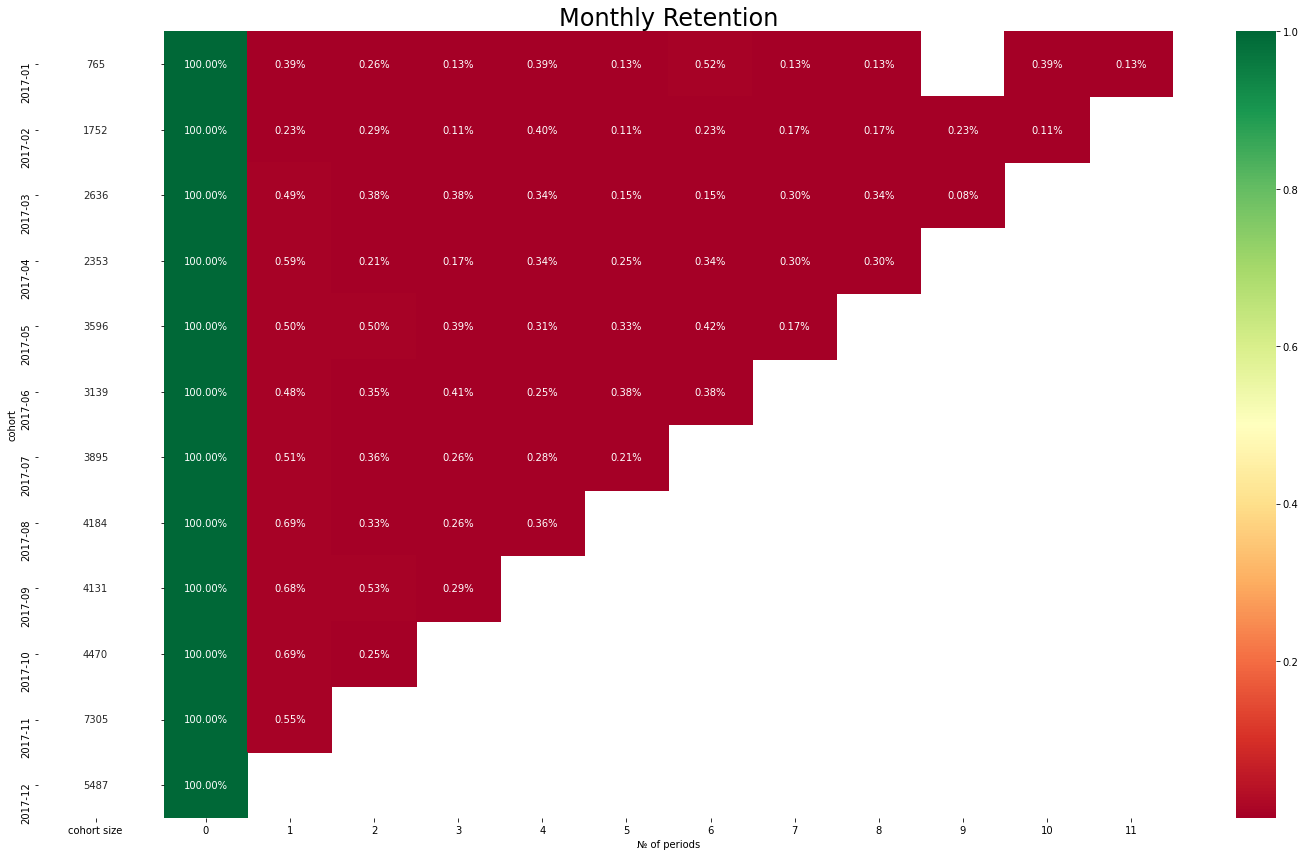

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(20, 12), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
sns.heatmap(retention_matrix,
            mask=retention_matrix.isnull(),
            annot=True,
            fmt='.2%',
            cmap='RdYlGn',
            ax=ax[1])
ax[1].set_title('Monthly Retention', fontsize=24)
ax[1].set(xlabel='№ of periods', ylabel='')
cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort size'})
white_cmap = mcolors.ListedColormap(['white'])
sns.heatmap(cohort_size_df,
            annot=True,
            cbar=False,
            fmt='g',
            cmap=white_cmap,
            ax=ax[0])
fig.tight_layout()




In [49]:
retention_matrix.iloc[:,3].idxmax()

Period('2017-06', 'M')

Самый высокий retention 3 месяца в когорте 2017-06

# Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю.

Считаем Recency = количество дней с момента последней покупки

Подготовим данные

In [50]:
df1 = df_customers.merge(df_orders)
df_merged3 = df1.merge(df_items)

In [51]:
df_rfm = df_merged3.groupby(['customer_unique_id', 'order_purchase_timestamp', 'price'],  as_index=False)\
    .agg({'order_id' : 'nunique', 'price' : 'sum'})\
    .sort_values('order_id', ascending = False)\
    .rename(columns = {'order_id' : 'frequency', 'price' : 'monetary'}) 
#считаю именно уникальные Order_id (каждая позиция в заказе прописана отдельно)

У одного пользователя может быть несколько заказов, соотвественно, нужно взять последний.

In [52]:
# df['max_ever']=df.groupby(['id'])['value'].transform(max)

In [53]:
df_rfm['max_ever'] = df_rfm.groupby('customer_unique_id')['order_purchase_timestamp']\
    .transform(max)
df_rfm

,customer_unique_id,order_purchase_timestamp,frequency,monetary,max_ever
40648,66980c3775537536f77b434d74e520f5,2018-03-31 15:08:21,3,120.00,2018-03-31 15:08:21
89175,e13e8b789e5a8e6fe1445f924a4ed4f6,2018-06-01 13:39:44,3,76.47,2018-06-01 13:39:44
27909,46958f708ade6b6a88b2e5aca1e66de5,2017-08-30 06:22:58,2,71.80,2017-08-30 06:22:58
49550,7d08a8005756c215935d45bcc0e9a760,2017-01-08 19:27:22,2,259.80,2017-01-08 19:27:22
54340,897ecc46977d723a6e514f3ebe92c844,2018-06-21 13:37:25,2,65.80,2018-06-21 13:37:25
...,...,...,...,...,...
33744,5549e9f67a5d7feb36b0a0c05d12a77b,2018-08-05 19:41:36,1,18.90,2018-08-05 19:41:36
33743,5549bb76a47193fd53fe793e5fcb176f,2017-04-22 12:18:19,1,54.90,2017-04-22 12:18:19
33742,55488f8b90d7ef22a2ef74042a94685a,2017-07-17 17:39:21,1,205.00,2017-07-17 17:39:21
33741,55481ae32ead3c8c734d8acee5ccf3a2,2017-03-20 02:06:43,1,59.90,2017-03-20 02:06:43


In [54]:
df_rfm.sort_values('order_purchase_timestamp').groupby('customer_unique_id').last() 

#второй вариант, как найти максимлаьную дату

,order_purchase_timestamp,frequency,monetary,max_ever
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,1,129.90,2018-05-10 10:56:27
0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,1,18.90,2018-05-07 11:11:27
0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,1,69.00,2017-03-10 21:05:03
0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,1,25.99,2017-10-12 20:29:41
0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,1,180.00,2017-11-14 19:45:42
...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08 21:00:36,1,680.00,2017-06-08 21:00:36
fffea47cd6d3cc0a88bd621562a9d061,2017-12-10 20:07:56,1,64.89,2017-12-10 20:07:56
ffff371b4d645b6ecea244b27531430a,2017-02-07 15:49:16,1,89.90,2017-02-07 15:49:16


In [55]:
df_rfm.customer_unique_id.nunique() 

95420

In [56]:
df_rfm.describe(percentiles = [.20,.40,.60,.80,.90,.99])

,frequency,monetary
count,101223.000000,101223.000000
mean,1.000464,134.274263
std,0.022442,206.755728
min,1.000000,0.850000
20%,1.000000,38.850000
40%,1.000000,65.000000
50%,1.000000,84.000000
60%,1.000000,102.000000
80%,1.000000,169.900000
90%,1.000000,259.900000


In [57]:
df_rfm.groupby(['customer_unique_id', 'max_ever', 'frequency'], as_index=False).\
    agg({'monetary':sum}) 
#считаем Monterary просуммировав суммы заказов по каждому покупателю

,customer_unique_id,max_ever,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,1,18.90
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,1,180.00
...,...,...,...,...
95423,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08 21:00:36,1,1570.00
95424,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10 20:07:56,1,64.89
95425,ffff371b4d645b6ecea244b27531430a,2017-02-07 15:49:16,1,89.90
95426,ffff5962728ec6157033ef9805bacc48,2018-05-02 15:17:41,1,115.00


In [58]:
#Для рассчета недавности возьмем самый последний день заказа, предположу, что я делаю анализ в 2018 году,
#и у мня самые сежие данные, на сегодняшний день

date_0 = df_rfm.max_ever.max()
df_rfm ['current_date'] = date_0
df_rfm ['current_date'] =pd.to_datetime  (df_rfm ['current_date'])
df_rfm ['day_diff'] = (df_rfm['current_date'] - df_rfm['max_ever']).dt.days #вывести только дни
df_rfm

,customer_unique_id,order_purchase_timestamp,frequency,monetary,max_ever,current_date,day_diff
40648,66980c3775537536f77b434d74e520f5,2018-03-31 15:08:21,3,120.00,2018-03-31 15:08:21,2018-09-03 09:06:57,155
89175,e13e8b789e5a8e6fe1445f924a4ed4f6,2018-06-01 13:39:44,3,76.47,2018-06-01 13:39:44,2018-09-03 09:06:57,93
27909,46958f708ade6b6a88b2e5aca1e66de5,2017-08-30 06:22:58,2,71.80,2017-08-30 06:22:58,2018-09-03 09:06:57,369
49550,7d08a8005756c215935d45bcc0e9a760,2017-01-08 19:27:22,2,259.80,2017-01-08 19:27:22,2018-09-03 09:06:57,602
54340,897ecc46977d723a6e514f3ebe92c844,2018-06-21 13:37:25,2,65.80,2018-06-21 13:37:25,2018-09-03 09:06:57,73
...,...,...,...,...,...,...,...
33744,5549e9f67a5d7feb36b0a0c05d12a77b,2018-08-05 19:41:36,1,18.90,2018-08-05 19:41:36,2018-09-03 09:06:57,28
33743,5549bb76a47193fd53fe793e5fcb176f,2017-04-22 12:18:19,1,54.90,2017-04-22 12:18:19,2018-09-03 09:06:57,498
33742,55488f8b90d7ef22a2ef74042a94685a,2017-07-17 17:39:21,1,205.00,2017-07-17 17:39:21,2018-09-03 09:06:57,412
33741,55481ae32ead3c8c734d8acee5ccf3a2,2017-03-20 02:06:43,1,59.90,2017-03-20 02:06:43,2018-09-03 09:06:57,532


In [59]:
df_rfm.describe(percentiles = [.20,.40,.60,.80,.90,.99])

,frequency,monetary,day_diff
count,101223.000000,101223.000000,101223.000000
mean,1.000464,134.274263,241.646167
std,0.022442,206.755728,152.923373
min,1.000000,0.850000,0.000000
20%,1.000000,38.850000,96.000000
40%,1.000000,65.000000,181.000000
50%,1.000000,84.000000,222.000000
60%,1.000000,102.000000,272.000000
80%,1.000000,169.900000,386.000000
90%,1.000000,259.900000,470.000000


Добавим коэффициент значения Monetory - M,
выделяем три группы по сумме заказов. Средний чек 134, и учитывая, что 90% покупают до 259, разделим сегменты на 0-134, 134-259, 259 и выше значене 13440 - это сильный выпад из общих сумм заказов

Коэфициент F - учитвая что 99% делаю 1 заказ, разделяю frequency, 1- 2, 2-3 и больше 3

Коэфициент R recently, я не знаю, какие товары покупают пользователи данного датасета, и в какой валюте, не могу предположить их ценность, но, учитывая, что большинство покупает 1 раз, и в среднем раз в 241 день, предположу, что имеет смысл смотреть на разбивки по годам. 2016,2017,2018 

In [60]:
df_rfm.order_purchase_timestamp.min()

Timestamp('2016-09-04 21:15:19')

In [61]:
df_rfm.order_purchase_timestamp.max()

Timestamp('2018-09-03 09:06:57')

In [62]:
from datetime import datetime
def m_coef(x):
    if x <= 134:
        return 1
    elif x <= 259:
        return 2
    else:
        return 3
    
def f_coef(x):
    if x <= 2:
        return 1
    elif x <= 3:
        return 2
    else:
        return 3
    
ts1= datetime.strptime('2016-12-31', '%Y-%m-%d')
ts2= datetime.strptime('2017-12-31', '%Y-%m-%d')
ts3= datetime.strptime('2018-12-31', '%Y-%m-%d')
    
def r_coef(x):
    if x <= ts1:
        return 1
    elif x <= ts2:
        return 2
    else:
        return 3

In [63]:
df_rfm['M'] = df_rfm['monetary'].apply(lambda x: m_coef(x))
df_rfm['F'] = df_rfm['frequency'].apply(lambda x: f_coef(x))
df_rfm['R'] = df_rfm['order_purchase_timestamp'].apply(lambda x: r_coef(x))

In [64]:
df_rfm

,customer_unique_id,order_purchase_timestamp,frequency,monetary,max_ever,current_date,day_diff,M,F,R
40648,66980c3775537536f77b434d74e520f5,2018-03-31 15:08:21,3,120.00,2018-03-31 15:08:21,2018-09-03 09:06:57,155,1,2,3
89175,e13e8b789e5a8e6fe1445f924a4ed4f6,2018-06-01 13:39:44,3,76.47,2018-06-01 13:39:44,2018-09-03 09:06:57,93,1,2,3
27909,46958f708ade6b6a88b2e5aca1e66de5,2017-08-30 06:22:58,2,71.80,2017-08-30 06:22:58,2018-09-03 09:06:57,369,1,1,2
49550,7d08a8005756c215935d45bcc0e9a760,2017-01-08 19:27:22,2,259.80,2017-01-08 19:27:22,2018-09-03 09:06:57,602,3,1,2
54340,897ecc46977d723a6e514f3ebe92c844,2018-06-21 13:37:25,2,65.80,2018-06-21 13:37:25,2018-09-03 09:06:57,73,1,1,3
...,...,...,...,...,...,...,...,...,...,...
33744,5549e9f67a5d7feb36b0a0c05d12a77b,2018-08-05 19:41:36,1,18.90,2018-08-05 19:41:36,2018-09-03 09:06:57,28,1,1,3
33743,5549bb76a47193fd53fe793e5fcb176f,2017-04-22 12:18:19,1,54.90,2017-04-22 12:18:19,2018-09-03 09:06:57,498,1,1,2
33742,55488f8b90d7ef22a2ef74042a94685a,2017-07-17 17:39:21,1,205.00,2017-07-17 17:39:21,2018-09-03 09:06:57,412,2,1,2
33741,55481ae32ead3c8c734d8acee5ccf3a2,2017-03-20 02:06:43,1,59.90,2017-03-20 02:06:43,2018-09-03 09:06:57,532,1,1,2


Охарактеризуем наших покупателей:

По давности заказа (recency):

1 — давние клиенты;
2 — относительно недавние клиенты;
3 — недавние клиенты.

По частоте покупок (frequency):

1 — покупает очень редко (единичные заказы);
2 — покупает нечасто;
3 — покупает часто.

По сумме покупок (monetary):

1 — маленькая сумма;
2 — средняя сумма;
3 — большая сумма.

Существует 27 комбинаций клиентов, каждый из таких клстеров можно применить для целевого действия (например таргетной рассылке)

Попробуем проанализировать полученные данные:

In [65]:
rfm_pivot = df_rfm.groupby(['R', 'F', 'M'], as_index=False)\
    .agg('customer_unique_id').count()
rfm_pivot['part_of_all'] = rfm_pivot.customer_unique_id /  rfm_pivot.customer_unique_id.sum() *100
rfm_pivot

,R,F,M,customer_unique_id,part_of_all
0,1,1,1,215,0.212402
1,1,1,2,54,0.053348
2,1,1,3,51,0.050384
3,2,1,1,32605,32.211059
4,2,1,2,8307,8.206633
5,2,1,3,4714,4.657044
6,3,1,1,39136,38.663150
7,3,1,2,10700,10.570720
8,3,1,3,5439,5.373285
9,3,2,1,2,0.001976


111 - давние клиенты с единоразовой покупкой на маленькую сумму УПУЩЕННЫЕ менее 1%\
112 - давние клиенты с единоразовой покупкой на среднюю сумму УПУЩЕННЫЕ менее 1%\
113 - давние клиенты с единоразовой покупкой на высокую сумму ПОТЕНЦИАЛЬНЫЕ менее 1%\
211 - не очень давние клиенты с единоразовой покупкой на маленькую сумму СПЯЩИЕ 32% нужно с ними работать\
212 - не очень давние клиенты с единоразовой покупкой на среднюю сумму СПЯЩИЕ 8% нужно с ними работать\
213 - не очень давние клиенты с единоразовой покупкой на большую сумму ТРЕБУЮТ КОММУНИКАЦИИ 5% возможно VIP \
311 - недавние клиенты с единоразовой покупкой на маленькую сумму 38% - активные, нужно работать  \
312 - недавние клиенты с единоразовой покупкой на среднюю сумму НУЖНО УДЕРЖИВАТЬ 10%\
313 - недавние клиенты с единоразовой покупкой на большую сумму ЛИЧНЫЙ МЕНЕДЖЕР 5,37% !!!! возможно VIP\
321 - недавние клиенты с повторными покупками на маленькую сумму - возможно начали работать над вовзращаемостью клиентов...